In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/master/init.py
import init; init.init(force_download=False);
from IPython.display import Image

replicating local resources


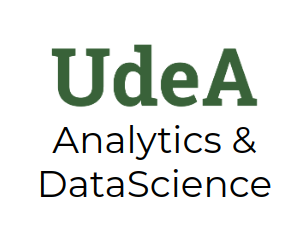

In [2]:
Image("local/imgs/udea-datascience.png")

# **TALLER 3: Machine Learning**
## Desarrollado por: Mg. Efraín Alberto Oviedo
## Universidad de Antioquia



**Nombre Completo:**
- Maria Isabel Duque Buitrago
- Cristhian Camilo Ocampo Bolivar
- Leidy Estefanía Silva Torres

**Cédula:**
- 1.037.666.575
- 1.152.220.729
- 1.020.479.068


**Correo Institucional:**
- maria.duqueb@udea.edu.co
- cristhian.ocampo@udea.edu.co
- estefania.silva@udea.edu.co

#**Análisis de pacientes de hospital de Envigado**

El archivo poblacion_atendida.csv contiene información sobre los pacientes atendidos en un Hospital en Envigado. Para cada paciente se tiene la siguiente información:

* SEXO
* ESTADO_CIVIL
* ZONA_RES
* MUN_RES
* PAIS_NCTO
* EDAD
* ESCOLARIDAD_PACIENTE

Fuente de los datos: https://www.datos.gov.co/Salud-y-Protecci-n-Social/Poblaci-n-Atendida-a-o-2020/4ike-xz34


Se solicita de su ayuda para realizar las siguientes actividades:

In [3]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

#SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

In [4]:
#SQL Context
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.types import *
sqlCtx = SQLContext(sc)

#Pandas

import pandas as pd


/content/spark-3.5.5-bin-hadoop3/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


##**A) Preparación de datos**

Revise cada una de las variables disponibles y realice la respectiva prepración de datos antes de proceder a crear los modelos de Machine Learning


Presente aquí el código desarrollado y el resultado obtenido

In [5]:
pacientesDF = sqlCtx.read.option("header",True) \
      .option("delimiter",";") \
     .csv("/content/local/data/poblacion_atendida.csv")
pacientesDF.show(5)

+--------+---------+---------------+--------+---------------+---------+----+--------------------+
|ID_UNICO|     SEXO|   ESTADO_CIVIL|ZONA_RES|        MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+--------+---------+---------------+--------+---------------+---------+----+--------------------+
|  676901|MASCULINO|     SOLTERO(A)|  URBANA|  ZONA BANANERA| COLOMBIA|  54|   BASICA SECUNDARIA|
|  676949|MASCULINO|    UNION LIBRE|  URBANA|       MEDELLIN| COLOMBIA|  27|     SIN INFORMACION|
|  676948|MASCULINO|SIN INFORMACION|  URBANA|SIN INFORMACION| COLOMBIA|   0|     SIN INFORMACION|
|  635991| FEMENINO|SIN INFORMACION|  URBANA|         ITAGUI| COLOMBIA|   0|     SIN INFORMACION|
|  676947| FEMENINO|     SOLTERO(A)|  URBANA|         ITAGUI| COLOMBIA|  24|   BASICA SECUNDARIA|
+--------+---------+---------------+--------+---------------+---------+----+--------------------+
only showing top 5 rows



In [6]:
pacientesDF.printSchema()

root
 |-- ID_UNICO: string (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- ESTADO_CIVIL: string (nullable = true)
 |-- ZONA_RES: string (nullable = true)
 |-- MUN_RES: string (nullable = true)
 |-- PAIS_NCTO: string (nullable = true)
 |-- EDAD: string (nullable = true)
 |-- ESCOLARIDAD_PACIENTE: string (nullable = true)



Con el objetivo de disminuir el número de cateogrias asociadas al estado civil, se decide establecer los registros con UNION LIBRE  como CASADO(A), SEPARADO y SIN INFORMACION por SOLTERO(A). Lo anterior implica que las categorias asociadas a la variable estado civil sean: **SOLTERO(A), CASADO(A) Y VIUDO(A).**

In [7]:
pacientesDF = pacientesDF.withColumn("ESTADO_CIVIL", functions.when(pacientesDF["ESTADO_CIVIL"] == "SIN INFORMACION", "SOLTERO(A)").otherwise(pacientesDF["ESTADO_CIVIL"]))
pacientesDF = pacientesDF.withColumn("ESTADO_CIVIL", functions.when(pacientesDF["ESTADO_CIVIL"] == "UNION LIBRE", "CASADO(A)").otherwise(pacientesDF["ESTADO_CIVIL"]))
pacientesDF = pacientesDF.withColumn("ESTADO_CIVIL", functions.when(pacientesDF["ESTADO_CIVIL"] == "SEPARADO", "SOLTERO(A)").otherwise(pacientesDF["ESTADO_CIVIL"]))
pacientesDF.show(5)

+--------+---------+------------+--------+---------------+---------+----+--------------------+
|ID_UNICO|     SEXO|ESTADO_CIVIL|ZONA_RES|        MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+--------+---------+------------+--------+---------------+---------+----+--------------------+
|  676901|MASCULINO|  SOLTERO(A)|  URBANA|  ZONA BANANERA| COLOMBIA|  54|   BASICA SECUNDARIA|
|  676949|MASCULINO|   CASADO(A)|  URBANA|       MEDELLIN| COLOMBIA|  27|     SIN INFORMACION|
|  676948|MASCULINO|  SOLTERO(A)|  URBANA|SIN INFORMACION| COLOMBIA|   0|     SIN INFORMACION|
|  635991| FEMENINO|  SOLTERO(A)|  URBANA|         ITAGUI| COLOMBIA|   0|     SIN INFORMACION|
|  676947| FEMENINO|  SOLTERO(A)|  URBANA|         ITAGUI| COLOMBIA|  24|   BASICA SECUNDARIA|
+--------+---------+------------+--------+---------------+---------+----+--------------------+
only showing top 5 rows



De igual manera, se decidio tener solo cinco categorias en la ESCOLARIDAD DEL PACIENTE, siendo estas **PREESCOLAR, BASICA, MEDIA, SUPERIOR y SIN INFORMACION**. Dentro de la categoria BASICA se encuentran los registros con escolaridad BASICA PRIMARIA y BASICA SECUNDARIA; en la categoria MEDIA se incluyen los registros para MEDIA ACADEMICA O CLASICA, MEDIA TECNICA (BACHILLERATO T) y NORMALISTA, por ultimo dentro de la categoria SUPERIOR se encuentran los registros correspondientes TECNICA PROFESIONAL, TECNOLOGICA, PROFESIONAL, DOCTORADO, ESPECIALIZACION Y MAESTRIA.

In [8]:
pacientesDF = pacientesDF.withColumn("ESCOLARIDAD_PACIENTE", functions.when(pacientesDF["ESCOLARIDAD_PACIENTE"] == "BASICA PRIMARIA", "BASICA").otherwise(pacientesDF["ESCOLARIDAD_PACIENTE"]))
pacientesDF = pacientesDF.withColumn("ESCOLARIDAD_PACIENTE", functions.when(pacientesDF["ESCOLARIDAD_PACIENTE"] == "BASICA SECUNDARIA", "BASICA").otherwise(pacientesDF["ESCOLARIDAD_PACIENTE"]))
pacientesDF = pacientesDF.withColumn("ESCOLARIDAD_PACIENTE", functions.when(pacientesDF["ESCOLARIDAD_PACIENTE"] == "MEDIA ACADEMICA O CLASICA", "MEDIA").otherwise(pacientesDF["ESCOLARIDAD_PACIENTE"]))
pacientesDF = pacientesDF.withColumn("ESCOLARIDAD_PACIENTE", functions.when(pacientesDF["ESCOLARIDAD_PACIENTE"] == "MEDIA TECNICA (BACHILLERATO T)", "MEDIA").otherwise(pacientesDF["ESCOLARIDAD_PACIENTE"]))
pacientesDF = pacientesDF.withColumn("ESCOLARIDAD_PACIENTE", functions.when(pacientesDF["ESCOLARIDAD_PACIENTE"] == "NORMALISTA", "MEDIA").otherwise(pacientesDF["ESCOLARIDAD_PACIENTE"]))
pacientesDF = pacientesDF.withColumn("ESCOLARIDAD_PACIENTE", functions.when(pacientesDF["ESCOLARIDAD_PACIENTE"] == "TECNICA PROFESIONAL", "SUPERIOR").otherwise(pacientesDF["ESCOLARIDAD_PACIENTE"]))
pacientesDF = pacientesDF.withColumn("ESCOLARIDAD_PACIENTE", functions.when(pacientesDF["ESCOLARIDAD_PACIENTE"] == "TECNOLOGICA", "SUPERIOR").otherwise(pacientesDF["ESCOLARIDAD_PACIENTE"]))
pacientesDF = pacientesDF.withColumn("ESCOLARIDAD_PACIENTE", functions.when(pacientesDF["ESCOLARIDAD_PACIENTE"] == "PROFESIONAL", "SUPERIOR").otherwise(pacientesDF["ESCOLARIDAD_PACIENTE"]))
pacientesDF = pacientesDF.withColumn("ESCOLARIDAD_PACIENTE", functions.when(pacientesDF["ESCOLARIDAD_PACIENTE"] == "DOCTORADO", "SUPERIOR").otherwise(pacientesDF["ESCOLARIDAD_PACIENTE"]))
pacientesDF = pacientesDF.withColumn("ESCOLARIDAD_PACIENTE", functions.when(pacientesDF["ESCOLARIDAD_PACIENTE"] == "ESPECIALIZACION", "SUPERIOR").otherwise(pacientesDF["ESCOLARIDAD_PACIENTE"]))
pacientesDF = pacientesDF.withColumn("ESCOLARIDAD_PACIENTE", functions.when(pacientesDF["ESCOLARIDAD_PACIENTE"] == "MAESTRIA", "SUPERIOR").otherwise(pacientesDF["ESCOLARIDAD_PACIENTE"]))
pacientesDF.show(5)

+--------+---------+------------+--------+---------------+---------+----+--------------------+
|ID_UNICO|     SEXO|ESTADO_CIVIL|ZONA_RES|        MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+--------+---------+------------+--------+---------------+---------+----+--------------------+
|  676901|MASCULINO|  SOLTERO(A)|  URBANA|  ZONA BANANERA| COLOMBIA|  54|              BASICA|
|  676949|MASCULINO|   CASADO(A)|  URBANA|       MEDELLIN| COLOMBIA|  27|     SIN INFORMACION|
|  676948|MASCULINO|  SOLTERO(A)|  URBANA|SIN INFORMACION| COLOMBIA|   0|     SIN INFORMACION|
|  635991| FEMENINO|  SOLTERO(A)|  URBANA|         ITAGUI| COLOMBIA|   0|     SIN INFORMACION|
|  676947| FEMENINO|  SOLTERO(A)|  URBANA|         ITAGUI| COLOMBIA|  24|              BASICA|
+--------+---------+------------+--------+---------------+---------+----+--------------------+
only showing top 5 rows



Se encontró que la mayoria de los registros para pais de nacimiento corresponden a Colombia y Venezuela, teniendo en cuenta lo anterior se decidio asisgnar la categoria otros a los demas paises registrados.

In [9]:
pacientesDF = pacientesDF.withColumn(
  "PAIS_NCTO",
  functions.when(
  (pacientesDF["PAIS_NCTO"] != "COLOMBIA") & (pacientesDF["PAIS_NCTO"] != "VENEZUELA"),
  "OTROS"
  ).otherwise(pacientesDF["PAIS_NCTO"])
)

pacientesDF.show(5)

+--------+---------+------------+--------+---------------+---------+----+--------------------+
|ID_UNICO|     SEXO|ESTADO_CIVIL|ZONA_RES|        MUN_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+--------+---------+------------+--------+---------------+---------+----+--------------------+
|  676901|MASCULINO|  SOLTERO(A)|  URBANA|  ZONA BANANERA| COLOMBIA|  54|              BASICA|
|  676949|MASCULINO|   CASADO(A)|  URBANA|       MEDELLIN| COLOMBIA|  27|     SIN INFORMACION|
|  676948|MASCULINO|  SOLTERO(A)|  URBANA|SIN INFORMACION| COLOMBIA|   0|     SIN INFORMACION|
|  635991| FEMENINO|  SOLTERO(A)|  URBANA|         ITAGUI| COLOMBIA|   0|     SIN INFORMACION|
|  676947| FEMENINO|  SOLTERO(A)|  URBANA|         ITAGUI| COLOMBIA|  24|              BASICA|
+--------+---------+------------+--------+---------------+---------+----+--------------------+
only showing top 5 rows



Se eliminó la variable ID_UNICO, ya que no aporta valor al modelo de machine learning. Asimismo, se decidió eliminar la variable MUN_RES debido a la gran cantidad de categorías que presenta. Además, esta variable resulta irrelevante para el modelo, considerando que ya se cuenta con la variable ZONA_RES, la cual clasifica en categorías más generales (urbana y rural) que pueden aportar mayor valor al proceso de clustering.

In [10]:
pacientesDF = pacientesDF.drop("MUN_RES","ID_UNICO")
pacientesDF.show(5)

+---------+------------+--------+---------+----+--------------------+
|     SEXO|ESTADO_CIVIL|ZONA_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+---------+------------+--------+---------+----+--------------------+
|MASCULINO|  SOLTERO(A)|  URBANA| COLOMBIA|  54|              BASICA|
|MASCULINO|   CASADO(A)|  URBANA| COLOMBIA|  27|     SIN INFORMACION|
|MASCULINO|  SOLTERO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
| FEMENINO|  SOLTERO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
| FEMENINO|  SOLTERO(A)|  URBANA| COLOMBIA|  24|              BASICA|
+---------+------------+--------+---------+----+--------------------+
only showing top 5 rows



Durante la exploración de los datos, se identificaron registros con valores de EDAD igual a 0. Aunque este valor podría corresponder a pacientes menores de 12 meses, se detectaron casos en los que la edad es 0 pero el ESTADO_CIVIL es diferente a "SOLTERO(A)", lo cual sugiere posibles errores de digitación o inconsistencias en la información. Por esta razón, se decidió eliminar los registros que presentan una edad igual a cero y un estado civil distinto a "SOLTERO(A)", con el fin de mejorar la calidad de los datos utilizados en la construcción del modelo de clustering.

In [11]:
pacientes_filtrados = pacientesDF.filter(
  (pacientesDF["EDAD"] == 0) & (pacientesDF["ESTADO_CIVIL"] != "SOLTERO(A)")
)

pacientes_filtrados.show()

+---------+------------+--------+---------+----+--------------------+
|     SEXO|ESTADO_CIVIL|ZONA_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+---------+------------+--------+---------+----+--------------------+
| FEMENINO|   CASADO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
|MASCULINO|   CASADO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
| FEMENINO|   CASADO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
|MASCULINO|   CASADO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
| FEMENINO|   CASADO(A)|  URBANA| COLOMBIA|   0|              BASICA|
|MASCULINO|   CASADO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
| FEMENINO|   CASADO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
|MASCULINO| SEPARADO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
+---------+------------+--------+---------+----+--------------------+



In [12]:
columns_to_join = pacientesDF.columns

pacientesDF_cleaned = pacientesDF.join(
    pacientes_filtrados,
    on=columns_to_join,
    how="left_anti"
)

pacientesDF_cleaned.show(5)
pacientesDF_cleaned.printSchema()

print(f"Original count: {pacientesDF.count()}")
print(f"Filtered count: {pacientes_filtrados.count()}")
print(f"Cleaned count: {pacientesDF_cleaned.count()}")

+---------+------------+--------+---------+----+--------------------+
|     SEXO|ESTADO_CIVIL|ZONA_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+---------+------------+--------+---------+----+--------------------+
|MASCULINO|  SOLTERO(A)|  URBANA| COLOMBIA|  54|              BASICA|
|MASCULINO|   CASADO(A)|  URBANA| COLOMBIA|  27|     SIN INFORMACION|
|MASCULINO|  SOLTERO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
| FEMENINO|  SOLTERO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
| FEMENINO|  SOLTERO(A)|  URBANA| COLOMBIA|  24|              BASICA|
+---------+------------+--------+---------+----+--------------------+
only showing top 5 rows

root
 |-- SEXO: string (nullable = true)
 |-- ESTADO_CIVIL: string (nullable = true)
 |-- ZONA_RES: string (nullable = true)
 |-- PAIS_NCTO: string (nullable = true)
 |-- EDAD: string (nullable = true)
 |-- ESCOLARIDAD_PACIENTE: string (nullable = true)

Original count: 55962
Filtered count: 8
Cleaned count: 55954


In [13]:
pacientesDF=pacientesDF_cleaned
pacientesDF.show(5)

+---------+------------+--------+---------+----+--------------------+
|     SEXO|ESTADO_CIVIL|ZONA_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+---------+------------+--------+---------+----+--------------------+
|MASCULINO|  SOLTERO(A)|  URBANA| COLOMBIA|  54|              BASICA|
|MASCULINO|   CASADO(A)|  URBANA| COLOMBIA|  27|     SIN INFORMACION|
|MASCULINO|  SOLTERO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
| FEMENINO|  SOLTERO(A)|  URBANA| COLOMBIA|   0|     SIN INFORMACION|
| FEMENINO|  SOLTERO(A)|  URBANA| COLOMBIA|  24|              BASICA|
+---------+------------+--------+---------+----+--------------------+
only showing top 5 rows



##**B) Análisis Descriptivo**

Cree un modelo de Kmeans que permitan describir los tipos de pacientes del hospital

Presente aquí el código desarrollado y el resultado obtenido

Para la creación del modelo es necesario asignar variables numericos a cada una de las variables categoricas:

In [14]:
def func_Sexo(value):
  if value=="FEMENINO":
    return 0
  else:
    return 1

In [15]:
def func_Est_Civil(value):
  if value=="SOLTERO(A)":
    return 0
  if value=="CASADO(A)":
    return 1
  if value=="VIUDO(A)":
    return 2

In [16]:
def func_Zona_Res(value):
  if value=="URBANA":
    return 0
  else:
    return 1

In [17]:
def func_Pais_Ncto(value):
  if value=="COLOMBIA":
    return 0
  if value=="VENEZUELA":
    return 1
  if value=="OTROS":
    return 2

In [18]:
def func_Escolaridad(value):
  if value=="PREESCOLAR":
    return 0
  if value=="SIN INFORMACION":
    return 1
  if value=="BASICA":
    return 2
  if value=="MEDIA":
    return 3
  if value=="SUPERIOR":
    return 4

In [19]:
pacientesDF.registerTempTable("pacientes")
sqlCtx.registerFunction("func_Sexo",func_Sexo)
sqlCtx.registerFunction("func_Est_Civil",func_Est_Civil)
sqlCtx.registerFunction("func_Zona_Res",func_Zona_Res)
sqlCtx.registerFunction("func_Pais_Ncto",func_Pais_Ncto)
sqlCtx.registerFunction("func_Escolaridad",func_Escolaridad)

/content/spark-3.5.5-bin-hadoop3/python/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)
/content/spark-3.5.5-bin-hadoop3/python/pyspark/sql/context.py:296: FutureWarning: Deprecated in 2.3.0. Use spark.udf.register instead.
  warnings.warn("Deprecated in 2.3.0. Use spark.udf.register instead.", FutureWarning)


<function __main__.func_Escolaridad(value)>

In [20]:
pacientes = sqlCtx.sql("""
        SELECT func_Sexo(SEXO) AS SexoInt, func_Est_Civil(ESTADO_CIVIL) AS Est_CivilInt,
        func_Zona_Res(ZONA_RES) AS Zona_ResInt, func_Pais_Ncto(PAIS_NCTO) AS Pais_NctoInt,
        func_Escolaridad(ESCOLARIDAD_PACIENTE) AS EscolaridadInt, EDAD as EDAD
        FROM Pacientes
        """)
pacientes.distinct().show(5)

+-------+------------+-----------+------------+--------------+----+
|SexoInt|Est_CivilInt|Zona_ResInt|Pais_NctoInt|EscolaridadInt|EDAD|
+-------+------------+-----------+------------+--------------+----+
|      0|           0|          0|           0|             2|  30|
|      0|           2|          0|           0|             1|  54|
|      1|           2|          0|           2|             2|  91|
|      1|           1|          0|           0|             4|  85|
|      1|           0|          0|           0|             3|  18|
+-------+------------+-----------+------------+--------------+----+
only showing top 5 rows



In [21]:
pacientes.printSchema()

root
 |-- SexoInt: string (nullable = true)
 |-- Est_CivilInt: string (nullable = true)
 |-- Zona_ResInt: string (nullable = true)
 |-- Pais_NctoInt: string (nullable = true)
 |-- EscolaridadInt: string (nullable = true)
 |-- EDAD: string (nullable = true)



In [22]:
pacientes=pacientes.withColumn("SexoInt",pacientes["SexoInt"].cast(IntegerType()))
pacientes=pacientes.withColumn("Est_CivilInt",pacientes["Est_CivilInt"].cast(IntegerType()))
pacientes=pacientes.withColumn("Zona_ResInt",pacientes["Zona_ResInt"].cast(IntegerType()))
pacientes=pacientes.withColumn("Pais_NctoInt",pacientes["Pais_NctoInt"].cast(IntegerType()))
pacientes=pacientes.withColumn("EscolaridadInt",pacientes["EscolaridadInt"].cast(IntegerType()))
pacientes=pacientes.withColumn("EDAD",pacientes["EDAD"].cast(IntegerType()))
pacientes.printSchema()

root
 |-- SexoInt: integer (nullable = true)
 |-- Est_CivilInt: integer (nullable = true)
 |-- Zona_ResInt: integer (nullable = true)
 |-- Pais_NctoInt: integer (nullable = true)
 |-- EscolaridadInt: integer (nullable = true)
 |-- EDAD: integer (nullable = true)



In [23]:
pacientes.distinct().show(5)

+-------+------------+-----------+------------+--------------+----+
|SexoInt|Est_CivilInt|Zona_ResInt|Pais_NctoInt|EscolaridadInt|EDAD|
+-------+------------+-----------+------------+--------------+----+
|      0|           1|          0|           0|             2|  76|
|      1|           1|          0|           0|             4|  36|
|      1|           1|          0|           0|             2|  79|
|      0|           1|          0|           0|             2|  25|
|      1|           0|          0|           0|             1|  22|
+-------+------------+-----------+------------+--------------+----+
only showing top 5 rows



Modelo:

In [24]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = pacientes.columns, outputCol = 'features', handleInvalid="skip")
vdata = vectorAssembler.transform(pacientes)
vdata.cache()
vdata.show(5)

+-------+------------+-----------+------------+--------------+----+--------------------+
|SexoInt|Est_CivilInt|Zona_ResInt|Pais_NctoInt|EscolaridadInt|EDAD|            features|
+-------+------------+-----------+------------+--------------+----+--------------------+
|      1|           0|          0|           0|             2|  54|[1.0,0.0,0.0,0.0,...|
|      1|           1|          0|           0|             1|  27|[1.0,1.0,0.0,0.0,...|
|      1|           0|          0|           0|             1|   0| (6,[0,4],[1.0,1.0])|
|      0|           0|          0|           0|             1|   0|       (6,[4],[1.0])|
|      0|           0|          0|           0|             2|  24|(6,[4,5],[2.0,24.0])|
+-------+------------+-----------+------------+--------------+----+--------------------+
only showing top 5 rows



In [25]:
from pyspark.ml.clustering import KMeans
km = KMeans( featuresCol='features', k=3, predictionCol='cluster', distanceMeasure='euclidean')
km_model = km.fit(vdata)

In [26]:
predictions = km_model.transform(vdata)
predictions.distinct().show(5)

+-------+------------+-----------+------------+--------------+----+--------------------+-------+
|SexoInt|Est_CivilInt|Zona_ResInt|Pais_NctoInt|EscolaridadInt|EDAD|            features|cluster|
+-------+------------+-----------+------------+--------------+----+--------------------+-------+
|      0|           1|          0|           0|             2|  39|[0.0,1.0,0.0,0.0,...|      2|
|      0|           1|          0|           0|             4|  31|[0.0,1.0,0.0,0.0,...|      0|
|      0|           0|          0|           0|             2|  29|(6,[4,5],[2.0,29.0])|      0|
|      1|           0|          0|           0|             4|  48|[1.0,0.0,0.0,0.0,...|      2|
|      1|           0|          0|           0|             1|  19|[1.0,0.0,0.0,0.0,...|      0|
+-------+------------+-----------+------------+--------------+----+--------------------+-------+
only showing top 5 rows



In [27]:
centers = km_model.clusterCenters()
print("Centroides: ")
for center in centers:
  centerR=[round(num, 0) for num in center]
  print(centerR)
print("Variables")
pacientes.columns

Centroides: 
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(2.0), np.float64(18.0)]
[np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(2.0), np.float64(71.0)]
[np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(3.0), np.float64(44.0)]
Variables


['SexoInt',
 'Est_CivilInt',
 'Zona_ResInt',
 'Pais_NctoInt',
 'EscolaridadInt',
 'EDAD']

In [28]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(predictionCol='cluster')
silhouette = evaluator.evaluate(predictions)
print("Índice de la silueta = " + str(silhouette))

Índice de la silueta = 0.672795482241847


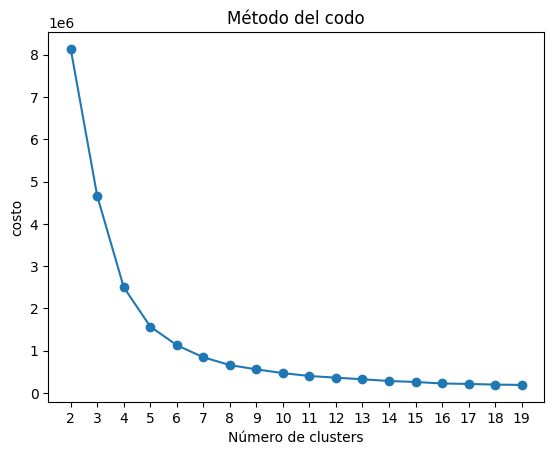

In [29]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
kini=2; kfin=20
ks = range(kini, kfin)
costo=[]
for k in range(kini, kfin):
    kmeans= KMeans( featuresCol='features', k=k, predictionCol='cluster', distanceMeasure='euclidean')
    model = kmeans.fit(vdata)
    costo.append(model.summary.trainingCost)
plt.plot(ks, costo, '-o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('costo')
plt.xticks(ks)
plt.show()

In [30]:
km2 = KMeans( featuresCol='features', k=5, predictionCol='cluster', distanceMeasure='euclidean')
km_model2 = km2.fit(vdata)
predictions2 = km_model2.transform(vdata)
predictions2.distinct().show()

+-------+------------+-----------+------------+--------------+----+--------------------+-------+
|SexoInt|Est_CivilInt|Zona_ResInt|Pais_NctoInt|EscolaridadInt|EDAD|            features|cluster|
+-------+------------+-----------+------------+--------------+----+--------------------+-------+
|      0|           1|          0|           0|             4|  52|[0.0,1.0,0.0,0.0,...|      4|
|      0|           2|          0|           0|             2|  68|[0.0,2.0,0.0,0.0,...|      4|
|      0|           0|          0|           0|             2|  87|(6,[4,5],[2.0,87.0])|      3|
|      1|           1|          0|           0|             1|  37|[1.0,1.0,0.0,0.0,...|      0|
|      1|           0|          0|           0|             3|  39|[1.0,0.0,0.0,0.0,...|      0|
|      0|           1|          0|           0|             1|  30|[0.0,1.0,0.0,0.0,...|      2|
|      1|           1|          0|           0|             4|  85|[1.0,1.0,0.0,0.0,...|      3|
|      1|           0|        

In [31]:
centers = km_model2.clusterCenters()
print("Centroides: ")
for center in centers:
  centerR=[round(num, 0) for num in center]
  print(centerR)
print("Variables")
pacientes.columns

Centroides: 
[np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(3.0), np.float64(42.0)]
[np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(5.0)]
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(3.0), np.float64(26.0)]
[np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(2.0), np.float64(80.0)]
[np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(2.0), np.float64(61.0)]
Variables


['SexoInt',
 'Est_CivilInt',
 'Zona_ResInt',
 'Pais_NctoInt',
 'EscolaridadInt',
 'EDAD']

In [32]:
evaluator = ClusteringEvaluator(predictionCol='cluster')
silhouette = evaluator.evaluate(predictions2)
print("Índice de la silueta = " + str(silhouette))

Índice de la silueta = 0.7145420902497638


In [33]:
num_rows = predictions2.count()
num_cols = len(predictions2.columns)

print((num_rows, num_cols))

(53788, 8)


In [34]:
predictions2.show(5)

+-------+------------+-----------+------------+--------------+----+--------------------+-------+
|SexoInt|Est_CivilInt|Zona_ResInt|Pais_NctoInt|EscolaridadInt|EDAD|            features|cluster|
+-------+------------+-----------+------------+--------------+----+--------------------+-------+
|      1|           0|          0|           0|             2|  54|[1.0,0.0,0.0,0.0,...|      4|
|      1|           1|          0|           0|             1|  27|[1.0,1.0,0.0,0.0,...|      2|
|      1|           0|          0|           0|             1|   0| (6,[0,4],[1.0,1.0])|      1|
|      0|           0|          0|           0|             1|   0|       (6,[4],[1.0])|      1|
|      0|           0|          0|           0|             2|  24|(6,[4,5],[2.0,24.0])|      2|
+-------+------------+-----------+------------+--------------+----+--------------------+-------+
only showing top 5 rows



In [35]:
type(predictions2)

pyspark.sql.dataframe.DataFrame

##**C) Análisis Predictivo**

Usando el clúster asignado a cada paciente como variable objetivo, cree un modelo predictivo que permita predecir el grupo al que pertenece cada paciente

Presente aquí el código desarrollado y el resultado obtenido

In [36]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
data = predictions2.select("features", "cluster")
data.show(5)

+--------------------+-------+
|            features|cluster|
+--------------------+-------+
|[1.0,0.0,0.0,0.0,...|      4|
|[1.0,1.0,0.0,0.0,...|      2|
| (6,[0,4],[1.0,1.0])|      1|
|       (6,[4],[1.0])|      1|
|(6,[4,5],[2.0,24.0])|      2|
+--------------------+-------+
only showing top 5 rows



In [37]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=42)
print("Entrenamiento:", trainingData.count())
print("Prueba:", testData.count())

Entrenamiento: 37659
Prueba: 16129


In [38]:
trainingData.groupBy("cluster").count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1| 4872|
|      3| 4700|
|      4| 8585|
|      2|12089|
|      0| 7413|
+-------+-----+



In [39]:
trainingData.groupBy("features").count().show()

+--------------------+-----+
|            features|count|
+--------------------+-----+
| (6,[4,5],[1.0,5.0])|   52|
|(6,[4,5],[1.0,80.0])|   13|
|(6,[4,5],[3.0,91.0])|    1|
|[0.0,0.0,0.0,1.0,...|    1|
|[0.0,2.0,0.0,0.0,...|    5|
|[0.0,2.0,0.0,0.0,...|   43|
|[1.0,0.0,0.0,0.0,...|    1|
|[1.0,0.0,0.0,0.0,...|    5|
|[1.0,0.0,0.0,0.0,...|   30|
|[1.0,1.0,0.0,0.0,...|    2|
|[1.0,1.0,0.0,0.0,...|    2|
|[1.0,1.0,0.0,2.0,...|    1|
|[1.0,1.0,1.0,0.0,...|    1|
|[1.0,2.0,0.0,0.0,...|    3|
|(6,[4,5],[1.0,97.0])|    1|
|(6,[4,5],[3.0,26.0])|   50|
|[0.0,0.0,0.0,1.0,...|    2|
|[0.0,1.0,0.0,0.0,...|   28|
|[0.0,1.0,0.0,0.0,...|   31|
|[1.0,0.0,0.0,1.0,...|    1|
+--------------------+-----+
only showing top 20 rows



In [40]:
lr = LogisticRegression(labelCol="cluster", featuresCol="features", maxIter=10)
lr_model = lr.fit(trainingData)

In [41]:
predictions_train = lr_model.transform(trainingData)
predictions_test = lr_model.transform(testData)

In [42]:
evaluator = MulticlassClassificationEvaluator(labelCol="cluster", predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator.evaluate(predictions_train)
print(f"Accuracy train: {accuracy_train:.4f}")
accuracy_test = evaluator.evaluate(predictions_test)
print(f"Accuracy test: {accuracy_test:.4f}")

Accuracy train: 0.9666
Accuracy test: 0.9671


##**D) Validación**

Cree un archivo con la información de un nuevo paciente por cada integrante del grupo y utilice el modelo de predicción creado anteriormente para predecir el clúster al que pertenecerían los nuevos pacientes

Presente aquí el código desarrollado y el resultado obtenido

In [58]:
validacionDF = sqlCtx.read.option("header",True) \
      .option("delimiter",";") \
     .csv("/content/validacion.csv")
validacionDF.show(5)

+---------+------------+--------+---------+----+--------------------+
|     SEXO|ESTADO_CIVIL|ZONA_RES|PAIS_NCTO|EDAD|ESCOLARIDAD_PACIENTE|
+---------+------------+--------+---------+----+--------------------+
|MASCULINO|  SOLTERO(A)|  URBANA| COLOMBIA|  27|            SUPERIOR|
| FEMENINO|  SOLTERO(A)|  URBANA|    OTROS|  26|            SUPERIOR|
| FEMENINO|    VIUDO(A)|   RURAL|VENEZUELA|  56|              BASICA|
+---------+------------+--------+---------+----+--------------------+



In [59]:
validacionDF.printSchema()

root
 |-- SEXO: string (nullable = true)
 |-- ESTADO_CIVIL: string (nullable = true)
 |-- ZONA_RES: string (nullable = true)
 |-- PAIS_NCTO: string (nullable = true)
 |-- EDAD: string (nullable = true)
 |-- ESCOLARIDAD_PACIENTE: string (nullable = true)



In [60]:
validacionDF.registerTempTable("pacientes_nuevos")
sqlCtx.registerFunction("func_Sexo",func_Sexo)
sqlCtx.registerFunction("func_Est_Civil",func_Est_Civil)
sqlCtx.registerFunction("func_Zona_Res",func_Zona_Res)
sqlCtx.registerFunction("func_Pais_Ncto",func_Pais_Ncto)
sqlCtx.registerFunction("func_Escolaridad",func_Escolaridad)

/content/spark-3.5.5-bin-hadoop3/python/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)
/content/spark-3.5.5-bin-hadoop3/python/pyspark/sql/context.py:296: FutureWarning: Deprecated in 2.3.0. Use spark.udf.register instead.
  warnings.warn("Deprecated in 2.3.0. Use spark.udf.register instead.", FutureWarning)


<function __main__.func_Escolaridad(value)>

In [61]:
pacientes_nuevos = sqlCtx.sql("""
        SELECT func_Sexo(SEXO) AS SexoInt, func_Est_Civil(ESTADO_CIVIL) AS Est_CivilInt,
        func_Zona_Res(ZONA_RES) AS Zona_ResInt, func_Pais_Ncto(PAIS_NCTO) AS Pais_NctoInt,
        func_Escolaridad(ESCOLARIDAD_PACIENTE) AS EscolaridadInt, EDAD as EDAD
        FROM Pacientes_nuevos
        """)
pacientes_nuevos.distinct().show(3)

+-------+------------+-----------+------------+--------------+----+
|SexoInt|Est_CivilInt|Zona_ResInt|Pais_NctoInt|EscolaridadInt|EDAD|
+-------+------------+-----------+------------+--------------+----+
|      0|           0|          0|           2|             4|  26|
|      0|           2|          1|           1|             2|  56|
|      1|           0|          0|           0|             4|  27|
+-------+------------+-----------+------------+--------------+----+



In [62]:
pacientes_nuevos=pacientes_nuevos.withColumn("SexoInt",pacientes_nuevos["SexoInt"].cast(IntegerType()))
pacientes_nuevos=pacientes_nuevos.withColumn("Est_CivilInt",pacientes_nuevos["Est_CivilInt"].cast(IntegerType()))
pacientes_nuevos=pacientes_nuevos.withColumn("Zona_ResInt",pacientes_nuevos["Zona_ResInt"].cast(IntegerType()))
pacientes_nuevos=pacientes_nuevos.withColumn("Pais_NctoInt",pacientes_nuevos["Pais_NctoInt"].cast(IntegerType()))
pacientes_nuevos=pacientes_nuevos.withColumn("EscolaridadInt",pacientes_nuevos["EscolaridadInt"].cast(IntegerType()))
pacientes_nuevos=pacientes_nuevos.withColumn("EDAD",pacientes_nuevos["EDAD"].cast(IntegerType()))
pacientes_nuevos.printSchema()

root
 |-- SexoInt: integer (nullable = true)
 |-- Est_CivilInt: integer (nullable = true)
 |-- Zona_ResInt: integer (nullable = true)
 |-- Pais_NctoInt: integer (nullable = true)
 |-- EscolaridadInt: integer (nullable = true)
 |-- EDAD: integer (nullable = true)



In [63]:
pacientes_nuevos.distinct().show(3)

+-------+------------+-----------+------------+--------------+----+
|SexoInt|Est_CivilInt|Zona_ResInt|Pais_NctoInt|EscolaridadInt|EDAD|
+-------+------------+-----------+------------+--------------+----+
|      0|           0|          0|           2|             4|  26|
|      1|           0|          0|           0|             4|  27|
|      0|           2|          1|           1|             2|  56|
+-------+------------+-----------+------------+--------------+----+



In [64]:
pacientes_nuevos_vdata = vectorAssembler.transform(pacientes_nuevos)
pacientes_nuevos_vdata.cache()
pacientes_nuevos_vdata.show(3)

+-------+------------+-----------+------------+--------------+----+--------------------+
|SexoInt|Est_CivilInt|Zona_ResInt|Pais_NctoInt|EscolaridadInt|EDAD|            features|
+-------+------------+-----------+------------+--------------+----+--------------------+
|      1|           0|          0|           0|             4|  27|[1.0,0.0,0.0,0.0,...|
|      0|           0|          0|           2|             4|  26|[0.0,0.0,0.0,2.0,...|
|      0|           2|          1|           1|             2|  56|[0.0,2.0,1.0,1.0,...|
+-------+------------+-----------+------------+--------------+----+--------------------+



In [68]:
pacientes_nuevos_prediction = km_model2.transform(pacientes_nuevos_vdata)

print("Predicción del cluster para los nuevos pacientes:")
pacientes_nuevos_prediction.select("features", "cluster").show()


Predicción del cluster para los nuevos pacientes:
+--------------------+-------+
|            features|cluster|
+--------------------+-------+
|[1.0,0.0,0.0,0.0,...|      2|
|[0.0,0.0,0.0,2.0,...|      2|
|[0.0,2.0,1.0,1.0,...|      4|
+--------------------+-------+



##**Análisis de los resultados**

Analice la calidad de los modelos obtenidos y presente sus conclusiones sobre el ejercicio:


En la etapa de clusterización y gracias al metodo del codo se logró establecer 5 cluster para categorizar la base de datos, a partir de clusterización se obtienen los siguientes centroides:

- Clúster 0: Mujeres casadas, zona urbana, colombianas, escolaridad media, edad promedio de 42 años
- Clúster 1: Hombres solteros, zona urbana, colombianos, sin información de escolaridad, edad promedio de 5 años
- Clúster 2: Mujeres solteras, zona urbana, colombianas, escolaridad media, edad promedio de 26 años
- Clúster 3: Mujeres casadas, zona urbana, colombianas, escolaridad básica, edad promedio de 80 años
- Clúster 4: Mujeres casadas, zona urbana, colombianas, escolaridad básica, edad promedio de 61 años

El indice de la silueta obtenido para el modelo de clusterización es de 0.7145 lo cual nos indica que los 5 clústeres están bien definidos, con una buena separación entre ellos y coherencia interna reflejo de un buen modelo.

Por otra parte, en la etapa de predicción, haciendo uso de un modelo de regresión logistica se presentan valores de precisión de 0.9666 y 0.9671 para entrenamiento y prueba respectivamente, lo cual refleja que el modelo funciona adecuadamente para clasificar los pacientes con base en su nivel educativo, zona residencial, pais de nacimiento, genero y edad. La similitud entre los valores de precisión para entrenamiento y modelo indica que el modelo generaliza bien lo cual es un indicio de que no hay sobreajuste.

En la etapa de validación, se observa que el modelo de clusterización le da un mayor peso a las vairables asociadas a la edad y escolaridad para categorizar los registros.